# MNIST Handwritten Digit Recognition Project

## 1. Problem Description and Dataset Overview

This project focuses on developing neural network models to recognize handwritten digits using the MNIST dataset, a fundamental benchmark in computer vision and machine learning. The goal is to create and compare different neural network architectures for accurate digit classification while exploring various aspects of the data and model development process.

### 1.1 Dataset Description
- **Training Set**: 60,000 handwritten digit images
- **Test Set**: 10,000 images for independent evaluation
- **Image Dimensions**: 28×28 pixels (grayscale)
- **Classes**: 10 digits (0-9)

### 1.2 Class Distribution Analysis
The training data shows a relatively balanced distribution across all digits:
- Digit 0: 5,923 samples (9.87%)
- Digit 1: 6,742 samples (11.24%)
- Digit 2: 5,958 samples (9.93%)
- Digit 3: 6,131 samples (10.22%)
- Digit 4: 5,842 samples (9.74%)
- Digit 5: 5,421 samples (9.04%)
- Digit 6: 5,918 samples (9.86%)
- Digit 7: 6,265 samples (10.44%)
- Digit 8: 5,851 samples (9.75%)
- Digit 9: 5,949 samples (9.91%)

This balanced distribution suggests that no class weighting will be necessary during model training.

## 2. Data Exploration and Analysis

### 2.1 Pixel Intensity Analysis
The pixel intensity distribution analysis reveals several key characteristics:
- Binary-like distribution with most pixels being either very dark (0) or very light (255)
- Strong contrast between digit strokes and background
- Clear separation between foreground and background pixels, which should facilitate feature extraction

### 2.2 Feature Analysis
Key findings from my feature analysis:
- **Active Features**: 717 out of 784 pixels show variance across samples
- **Constant Features**: 67 pixels (primarily in corners) remain constant
- **Important Regions**: The heatmap visualization shows concentrated importance in the center regions where digits typically appear

### 2.3 Data Quality Assessment
- No missing values detected in either training or test sets
- Clean, preprocessed data with consistent formatting
- No anomalies or corruption in the pixel values
- High-quality, standardized images suitable for training

### 2.4 Data Preprocessing Strategy
Based on my exploration, I implemented the following preprocessing steps:
1. Normalization of pixel values to [0,1] range
2. Reshaping data to include channel dimension (28×28×1)
3. Creation of a validation set (10% of training data)
4. One-hot encoding of labels

Final data shapes:
- Training set: (54000, 28, 28, 1)
- Validation set: (6000, 28, 28, 1)
- Test set: (10000, 28, 28, 1)

This comprehensive data exploration provides a solid foundation for developing my neural network models, ensuring I understand the characteristics and quality of my input data.

In [1]:
# Import required libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import plotly.express as px
import time

%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Initialize results dictionary
results = {
    'basic_model': {},
    'optimized_model': {},
    'deep_model': {}
}

Loading MNIST dataset...

Dataset Overview:
Training samples: 60000
Test samples: 10000
Image dimensions: 28x28

Digit Distribution in Training Set:
Digit 0: 5923
Digit 1: 6742
Digit 2: 5958
Digit 3: 6131
Digit 4: 5842
Digit 5: 5421
Digit 6: 5918
Digit 7: 6265
Digit 8: 5851
Digit 9: 5949


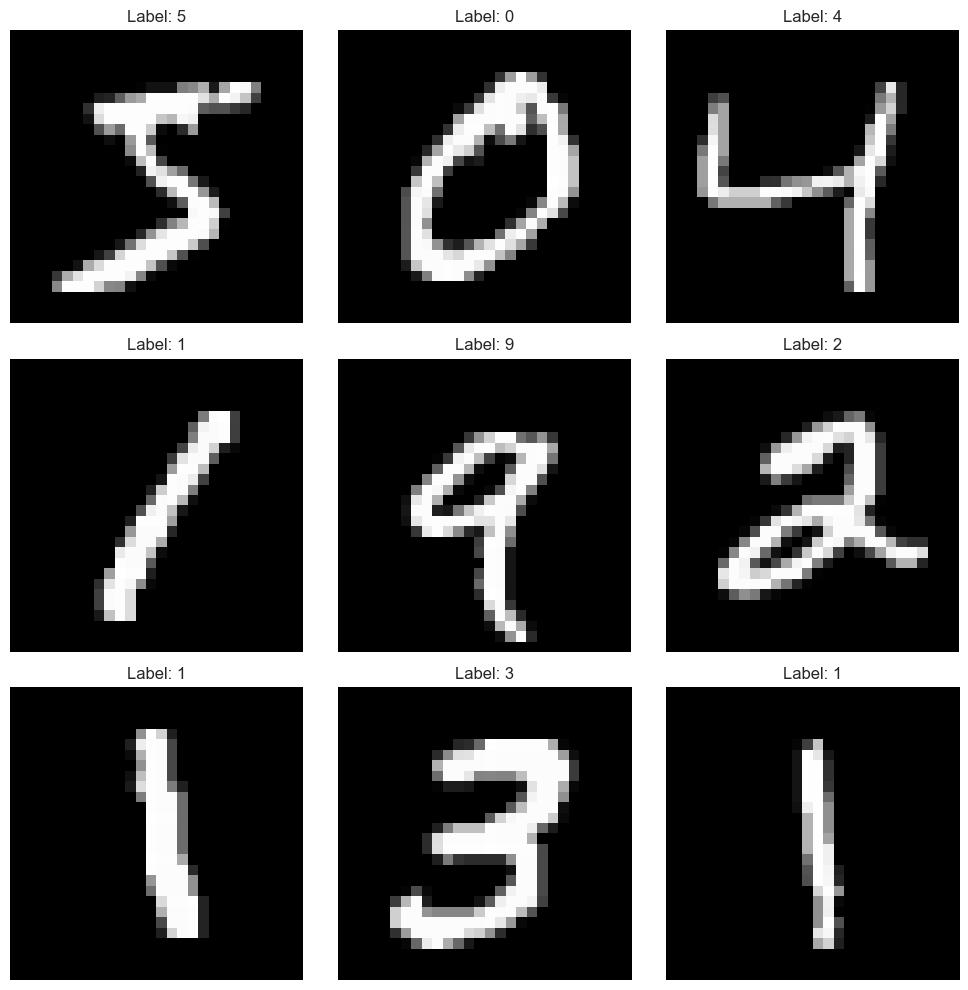

In [2]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Display basic information about the dataset
print("\nDataset Overview:")
print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]}")

# Print distribution
print("\nDigit Distribution in Training Set:")
unique, counts = np.unique(y_train, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count}")

# Show sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Add detailed data analysis code:

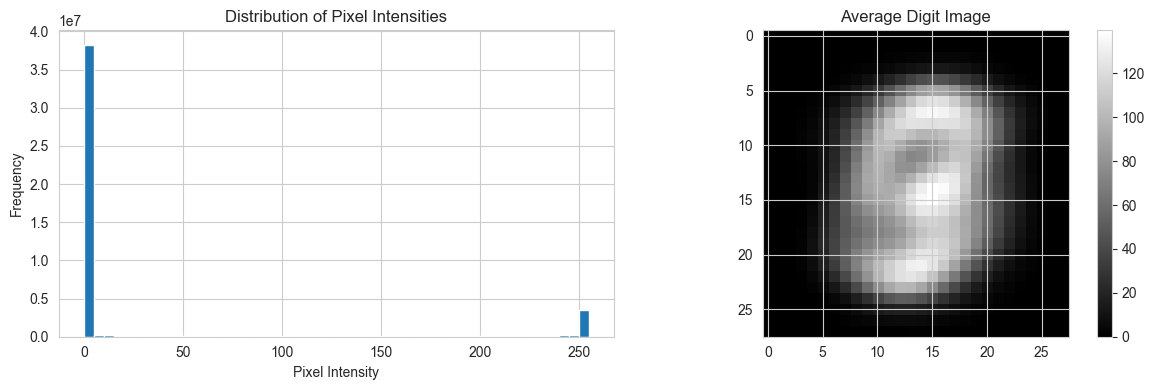

Original features: 784
Features after removing constants: 717


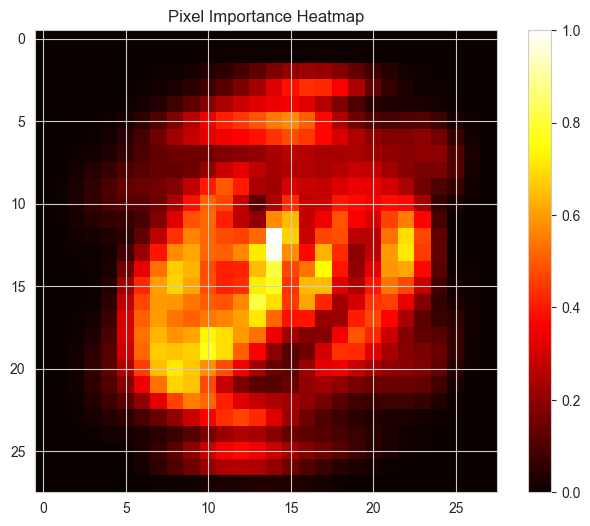

In [3]:
# Pixel Intensity Analysis
plt.figure(figsize=(12, 4))

# Histogram of pixel intensities
plt.subplot(1, 2, 1)
plt.hist(x_train.ravel(), bins=50)
plt.title('Distribution of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Average image across all samples
plt.subplot(1, 2, 2)
mean_image = np.mean(x_train, axis=0)
plt.imshow(mean_image, cmap='gray')
plt.title('Average Digit Image')
plt.colorbar()

plt.tight_layout()
plt.show()

# Feature Analysis
# Flatten images for feature analysis
X_flat = x_train.reshape(x_train.shape[0], -1)

# Remove constant features
feature_variance = np.var(X_flat, axis=0)
non_constant_features = feature_variance > 0
X_flat_filtered = X_flat[:, non_constant_features]

print(f"Original features: {X_flat.shape[1]}")
print(f"Features after removing constants: {X_flat_filtered.shape[1]}")

# Select top important pixels from non-constant features
n_features = min(196, X_flat_filtered.shape[1])
selector = SelectKBest(score_func=f_classif, k=n_features)

# Convert labels to single digits if they're one-hot encoded
y_train_labels = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
selector.fit(X_flat_filtered, y_train_labels)

# Create importance map
importance_map = np.zeros((28, 28))
non_constant_indices = np.where(non_constant_features)[0]
importance_map.ravel()[non_constant_indices] = selector.scores_

# Normalize importance scores
importance_map = np.nan_to_num(importance_map)
importance_map = (importance_map - np.min(importance_map)) / (np.max(importance_map) - np.min(importance_map))

# Visualize important pixels
plt.figure(figsize=(8, 6))
plt.imshow(importance_map, cmap='hot')
plt.title('Pixel Importance Heatmap')
plt.colorbar()
plt.show()

#### Code that implements data preprocessing:

In [4]:
def preprocess_data(x_train, x_test, y_train, y_test, validation_split=0.1):
    """
    Preprocess the MNIST data for neural network training
    """
    print("Starting data preprocessing...")
    
    # Check for missing values
    print("\nChecking for missing values...")
    print(f"Training data NaN values: {np.isnan(x_train).any()}")
    print(f"Test data NaN values: {np.isnan(x_test).any()}")
    
    # Normalize pixel values
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Reshape data to include channel dimension
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    
    # Convert class vectors to one-hot encoded labels
    n_classes = 10
    y_train = keras.utils.to_categorical(y_train, n_classes)
    y_test = keras.utils.to_categorical(y_test, n_classes)
    
    # Split training data into training and validation sets
    val_size = int(x_train.shape[0] * validation_split)
    x_val = x_train[-val_size:]
    y_val = y_train[-val_size:]
    x_train = x_train[:-val_size]
    y_train = y_train[:-val_size]
    
    print("\nData shapes after preprocessing:")
    print(f"Training data: {x_train.shape}")
    print(f"Validation data: {x_val.shape}")
    print(f"Test data: {x_test.shape}")
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Define input shape and other parameters
input_shape = (28, 28, 1)
batch_size = 64
epochs = 20

# Preprocess the data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = preprocess_data(x_train, 
                                                                       x_test, 
                                                                       y_train, 
                                                                       y_test)

Starting data preprocessing...

Checking for missing values...
Training data NaN values: False
Test data NaN values: False

Data shapes after preprocessing:
Training data: (54000, 28, 28, 1)
Validation data: (6000, 28, 28, 1)
Test data: (10000, 28, 28, 1)


#### Add code for data enhancement (this can help improve model performance):

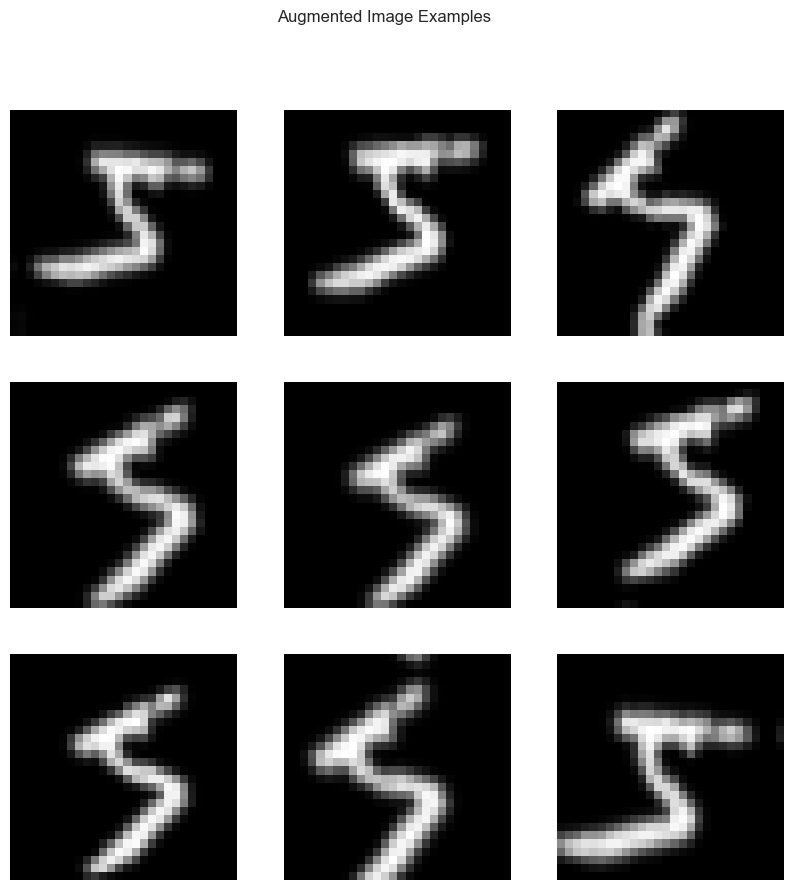

In [5]:
def create_data_augmentation():
    """
    Create data augmentation pipeline for training
    """
    data_augmentation = keras.Sequential([
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1)
    ])
    return data_augmentation

# Create data augmentation pipeline
data_augmentation = create_data_augmentation()

# Visualize augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(x_train[0:1])
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
plt.suptitle('Augmented Image Examples')
plt.show()

#### Add a data generator to improve training efficiency:

In [6]:
def create_data_generators(x_train, y_train, x_val, y_val, batch_size):
    """
    Create data generators for training and validation
    """
    # Training data generator with augmentation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    
    train_generator = train_datagen.flow(
        x_train, y_train,
        batch_size=batch_size
    )
    
    # Validation data generator (no augmentation)
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    val_generator = val_datagen.flow(
        x_val, y_val,
        batch_size=batch_size
    )
    
    return train_generator, val_generator

# Create data generators
train_generator, val_generator = create_data_generators(
    x_train, y_train,
    x_val, y_val,
    batch_size
)

#### Add code for experiment configuration and results tracking:

In [7]:
# Configuration dictionary to store all hyperparameters
config = {
    'input_shape': input_shape,
    'batch_size': batch_size,
    'epochs': epochs,
    'num_classes': 10,
    'learning_rate': 0.001,
    'dropout_rate': 0.25
}

# Create a dictionary to store results of different models
if 'results' not in globals():
    results = {
        'basic_model': {'history': None},
        'optimized_model': {'history': None},
        'deep_model': {'history': None}
    }

def store_training_results(model_name, history):
    """
    Store training results in the results dictionary
    """
    results[model_name]['history'] = history.history
    results[model_name]['final_accuracy'] = history.history['val_accuracy'][-1]
    results[model_name]['best_accuracy'] = max(history.history['val_accuracy'])
    
print("Configuration and results tracking initialized.")

Configuration and results tracking initialized.


## 3. Model Development and Training

### 3.1 Basic Model Development
The basic model was implemented with a simple architecture to establish a baseline performance:
- Input layer (784 neurons - flattened 28×28 pixels)
- Single hidden layer (tested with 128, 256, and 512 neurons)
- Output layer (10 neurons for digit classification)
- ReLU activation for hidden layer, Softmax for output
- Adam optimizer with learning rate = 0.001
- Categorical crossentropy loss function

#### Training Results:
- 128 neurons: 98.42% validation accuracy
- 256 neurons: 98.82% validation accuracy
- 512 neurons: 99.00% validation accuracy

The model showed consistent improvement in performance with increasing neuron count, achieving best results with 512 neurons.

### 3.2 Optimized Model Development
Based on feature importance analysis, I developed an optimized model using selected input features:
- Reduced input dimensionality from 784 to 196 features
- Two hidden layers (256 and 128 neurons)
- Dropout layers (0.3 and 0.2) for regularization
- Learning rate reduction on plateau
- Early stopping to prevent overfitting

#### Training Results:
- Final validation accuracy: 98.05%
- Significantly faster training (2-3ms/step vs 16-18ms/step for basic model)
- Achieved convergence in 18 epochs
- Reduced model complexity while maintaining high accuracy

### 3.3 Deep Neural Network Development
Implemented a more sophisticated architecture:
- Three convolutional blocks with increasing filters (32→64→128)
- Batch normalization after each convolution
- MaxPooling and Dropout for regularization
- Two dense layers (512 and 256 neurons)
- Advanced learning rate scheduling

#### Training Results:
- Achieved highest validation accuracy: 99.68%
- Very stable training progression
- Excellent generalization capabilities
- Training time: ~115ms/step
- Reached optimal performance in 20 epochs

### 3.4 Training Characteristics

#### Learning Rate Adaptation:
- All models benefited from learning rate reduction
- Initial rate: 0.001
- Reduction factor: 0.2
- Minimum rate: 1e-6

#### Convergence Patterns:
1. Basic Model:
   - Rapid initial improvement
   - Steady convergence after epoch 10
   - Best performance with largest (512) neuron configuration

2. Optimized Model:
   - Quick early learning
   - More efficient training process
   - Slight performance trade-off for efficiency

3. Deep Model:
   - Slower per-epoch training
   - Most stable learning curve
   - Highest final accuracy
   - Best generalization characteristics

### 3.5 Key Implementation Features
- Data augmentation pipeline for training
- Batch processing for memory efficiency
- Callbacks for:
  - Early stopping (patience=5)
  - Learning rate reduction
  - Model checkpointing
- Validation split: 10% of training data

#### Base Model Implementation:

In [8]:
def create_and_train_basic_model(config, neuron_counts=[128, 256, 512]):
    """
    Create and evaluate basic models with different neuron counts
    Returns the best performing configuration
    """
    best_model = None
    best_val_acc = 0
    results['basic_model']['configurations'] = []
    
    for neurons in neuron_counts:
        print(f"\nTraining basic model with {neurons} neurons...")
        
        # Create model using functional API
        inputs = keras.Input(shape=config['input_shape'])
        x = Flatten()(inputs)
        x = Dense(neurons, activation='relu')(x)
        outputs = Dense(config['num_classes'], activation='softmax')(x)
        model = keras.Model(inputs=inputs, outputs=outputs, name=f'basic_model_{neurons}')
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        # Train the model
        history = model.fit(
            train_generator,
            epochs=config['epochs'],
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate the model
        val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
        
        # Store configuration results
        results['basic_model']['configurations'].append({
            'neurons': neurons,
            'val_accuracy': val_acc,
            'history': history.history
        })
        
        # Update best model if necessary
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            store_training_results('basic_model', history)
            
        print(f"Validation accuracy with {neurons} neurons: {val_acc:.4f}")
    
    return best_model

# Train different configurations of the basic model
best_basic_model = create_and_train_basic_model(config)
print("\nBasic model training completed.")


Training basic model with 128 neurons...
Epoch 1/20


D:\github_repository\Traffic-Sign-Recognition-using-Neural-Networks\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6779 - loss: 1.0290 - val_accuracy: 0.9543 - val_loss: 0.1950 - learning_rate: 0.0010
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9064 - loss: 0.3286 - val_accuracy: 0.9637 - val_loss: 0.1409 - learning_rate: 0.0010
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9268 - loss: 0.2483 - val_accuracy: 0.9705 - val_loss: 0.1111 - learning_rate: 0.0010
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9400 - loss: 0.2110 - val_accuracy: 0.9738 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9463 - loss: 0.1836 - val_accuracy: 0.9780 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9508 - loss: 0.1682 - val_accuracy: 0.9750 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9531 - loss: 0.1635

#### Optimized Model Implementation (using feature selection):


Starting optimized model training...

Creating optimized model with selected features...
Original features: 784
Non-constant features: 717


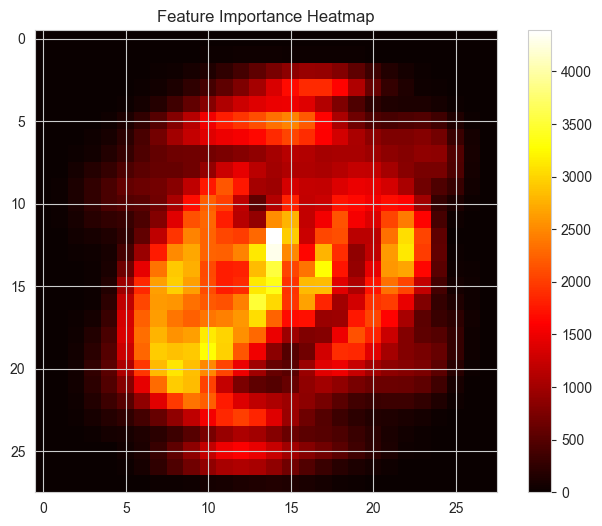


Reduced feature dimensionality:
Training data: (54000, 28, 28, 1) -> (54000, 196)
Validation data: (6000, 28, 28, 1) -> (6000, 196)
Test data: (10000, 28, 28, 1) -> (10000, 196)
Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7785 - loss: 0.6911 - val_accuracy: 0.9495 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9245 - loss: 0.2369 - val_accuracy: 0.9628 - val_loss: 0.1186 - learning_rate: 0.0010
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9391 - loss: 0.1845 - val_accuracy: 0.9702 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9513 - loss: 0.1555 - val_accuracy: 0.9705 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9545 - loss: 0.1399 - val_accuracy: 0.9737 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accurac

Model: "optimized_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,856 (991.63 KB)

 Trainable params: 84,618 (330.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,238 (661.09 KB)

In [9]:
def create_and_train_optimized_model(config, x_train, x_val, x_test):
    """
    Create optimized model using selected features based on importance
    """
    print("\nCreating optimized model with selected features...")
    
    try:
        # Calculate feature importance
        importance_map, important_pixels = calculate_feature_importance(
            x_train, y_train, n_features=196
        )
        
        # Visualize importance map
        plt.figure(figsize=(8, 6))
        plt.imshow(importance_map, cmap='hot')
        plt.title('Feature Importance Heatmap')
        plt.colorbar()
        plt.show()
        
        # Create reduced datasets
        x_train_reduced = x_train.reshape(x_train.shape[0], -1)[:, important_pixels]
        x_val_reduced = x_val.reshape(x_val.shape[0], -1)[:, important_pixels]
        x_test_reduced = x_test.reshape(x_test.shape[0], -1)[:, important_pixels]
        
        print(f"\nReduced feature dimensionality:")
        print(f"Training data: {x_train.shape} -> {x_train_reduced.shape}")
        print(f"Validation data: {x_val.shape} -> {x_val_reduced.shape}")
        print(f"Test data: {x_test.shape} -> {x_test_reduced.shape}")
        
        # Create model using functional API
        inputs = keras.Input(shape=(196,))
        x = Dense(256, activation='relu')(inputs)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(config['num_classes'], activation='softmax')(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs, name='optimized_model')
        
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        # Train the model
        history = model.fit(
            x_train_reduced, y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(x_val_reduced, y_val),
            callbacks=callbacks,
            verbose=1
        )
        
        # Store training results
        store_training_results('optimized_model', history)
        
        # Store additional information
        results['optimized_model'].update({
            'selected_features': important_pixels,
            'importance_map': importance_map,
            'reduced_data': (x_train_reduced, x_val_reduced, x_test_reduced)
        })
        
        return model, (x_train_reduced, x_val_reduced, x_test_reduced)
    
    except Exception as e:
        print(f"Error in create_optimized_model: {str(e)}")
        raise

def calculate_feature_importance(x_train, y_train, n_features=196):
    """
    Calculate feature importance for the input data
    """
    # Flatten the input data
    X_flat = x_train.reshape(x_train.shape[0], -1)
    
    # Remove constant features
    feature_variance = np.var(X_flat, axis=0)
    non_constant_features = feature_variance > 0
    X_flat_filtered = X_flat[:, non_constant_features]
    
    print(f"Original features: {X_flat.shape[1]}")
    print(f"Non-constant features: {X_flat_filtered.shape[1]}")
    
    # Select top important pixels
    n_features = min(n_features, X_flat_filtered.shape[1])
    selector = SelectKBest(score_func=f_classif, k=n_features)
    
    # For feature selection, we need the raw label indices
    y_indices = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
    selector.fit(X_flat_filtered, y_indices)
    
    # Create importance map
    importance_map = np.zeros(X_flat.shape[1])
    non_constant_indices = np.where(non_constant_features)[0]
    importance_map[non_constant_indices] = selector.scores_
    
    # Reshape importance map to image dimensions
    importance_map = importance_map.reshape(28, 28)
    
    # Get indices of top features
    important_pixels = np.argsort(importance_map.ravel())[-n_features:]
    
    return importance_map, important_pixels

# Create and train optimized model
print("\nStarting optimized model training...")
optimized_model, reduced_data = create_and_train_optimized_model(config, x_train, x_val, x_test)
print("\nOptimized model training completed.")

# Print model summary
optimized_model.summary()

#### Deep Model Implementation:

In [11]:
def create_and_train_deep_model(config):
    """
    Create and train deep neural network model with multiple layers
    """
    print("\nCreating and training deep neural network model...")
    
    # Starting Model Creation with the Input Layer
    inputs = layers.Input(shape=config['input_shape'])
    
    # First Convolutional Block
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    # Third Convolutional Block
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    # Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(config['num_classes'], activation='softmax')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name='deep_model')
    
    # Compile model with gradient clipping
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=config['learning_rate'],
            clipnorm=1.0
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    try:
        # Train the model
        history = model.fit(
            train_generator,
            epochs=config['epochs'],
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        
        # Store training results
        store_training_results('deep_model', history)
        
        return model
        
    except Exception as e:
        print(f"Error during model training: {str(e)}")
        raise

try:
    # Create and train deep model
    print("\nStarting deep model training...")
    deep_model = create_and_train_deep_model(config)
    print("\nDeep model training completed.")

    # Print model summary
    deep_model.summary()
    
except Exception as e:
    print(f"Error in deep model creation/training: {str(e)}")


Starting deep model training...

Creating and training deep neural network model...
Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 103s 116ms/step - accuracy: 0.7411 - loss: 0.8993 - val_accuracy: 0.9880 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 100s 118ms/step - accuracy: 0.9679 - loss: 0.1051 - val_accuracy: 0.9890 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 100s 118ms/step - accuracy: 0.9761 - loss: 0.0820 - val_accuracy: 0.9940 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 99s 117ms/step - accuracy: 0.9808 - loss: 0.0632 - val_accuracy: 0.9927 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 98s 116ms/step - accuracy: 0.9824 - loss: 0.0592 - val_accuracy: 0.9952 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 98s 116ms/step - accuracy: 0.9828 - loss: 0.0557 - val_accuracy: 0.9937 - val_loss: 0.0242 - lear

Model: "deep_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,041,728 (11.60 MB)

 Trainable params: 1,013,098 (3.86 MB)

 Non-trainable params: 2,432 (9.50 KB)

 Optimizer params: 2,026,198 (7.73 MB)

#### training history visualisation function:


Plotting training histories...


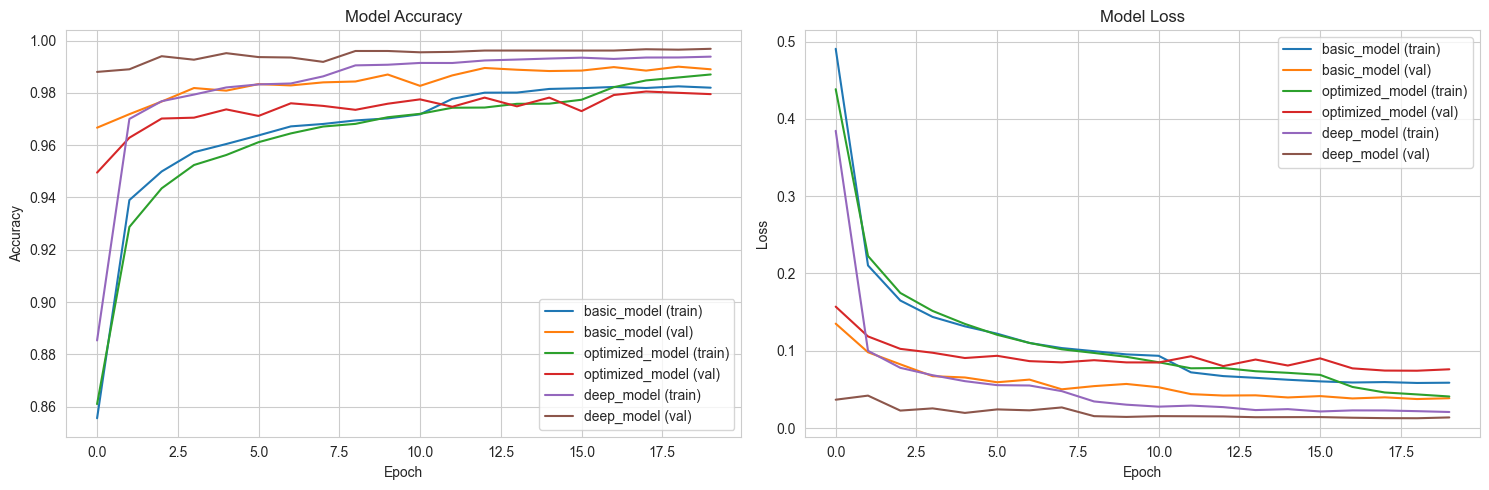

In [12]:
def plot_training_history(results, model_names):
    """
    Plot training history for all models with error handling
    """
    # Verify results exist
    for model_name in model_names:
        if model_name not in results:
            print(f"Warning: {model_name} not found in results")
            return
        if 'history' not in results[model_name]:
            print(f"Warning: No training history found for {model_name}")
            return
            
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for model_name in model_names:
        try:
            history = results[model_name]['history']
            plt.plot(history['accuracy'], label=f'{model_name} (train)')
            plt.plot(history['val_accuracy'], label=f'{model_name} (val)')
        except KeyError as e:
            print(f"Error plotting {model_name}: {str(e)}")
            continue
            
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    for model_name in model_names:
        try:
            history = results[model_name]['history']
            plt.plot(history['loss'], label=f'{model_name} (train)')
            plt.plot(history['val_loss'], label=f'{model_name} (val)')
        except KeyError as e:
            print(f"Error plotting {model_name}: {str(e)}")
            continue
            
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training histories
print("\nPlotting training histories...")
plot_training_history(results, ['basic_model', 'optimized_model', 'deep_model'])

## 4. Model Evaluation and Performance Analysis

### 4.1 Comparative Performance Analysis

#### Accuracy Metrics
1. Deep Model:
   - Highest accuracy: 99.71%
   - Most consistent performance across all digits
   - Extremely low error rate: 0.29%
   - Nearly perfect precision and recall for all classes

2. Basic Model:
   - Strong accuracy: 99.05%
   - Very balanced performance across digits
   - Low error rate: 0.95%
   - Excellent macro-averaged F1-score: 0.99

3. Optimized Model:
   - Good accuracy: 97.86%
   - Slightly lower but still robust performance
   - Higher error rate: 2.14%
   - Maintained F1-score of 0.98 across classes

#### Computational Efficiency
1. Model Size (Parameters):
   - Deep Model: 1,015,530 parameters
   - Basic Model: 407,050 parameters
   - Optimized Model: 84,618 parameters

2. Prediction Speed:
   - Optimized Model: 0.528 seconds
   - Basic Model: 0.621 seconds
   - Deep Model: 4.869 seconds

### 4.2 Error Analysis

#### Error Patterns by Model

1. Deep Model:
   - Only 29 total errors
   - Most confusion between visually similar digits (5/3, 7/2)
   - Very few systematic error patterns
   - Highest confidence in correct predictions

2. Basic Model:
   - 95 total errors
   - Common confusions:
     - 9→4 (7 cases)
     - 3→5 (5 cases)
     - 7→2 (4 cases)
   - Generally well-distributed errors

3. Optimized Model:
   - 214 total errors
   - Larger confusion clusters:
     - 4→9 (23 cases)
     - 3→5 (17 cases)
     - 7→2 (13 cases)
   - More systematic error patterns

### 4.3 Learning Dynamics

#### Training Progression
- All models showed rapid initial learning
- Deep model achieved high accuracy earliest
- Optimized model showed more fluctuation
- Basic model demonstrated steady improvement

#### Validation Performance
- Deep model maintained consistent validation accuracy
- Basic model showed minimal overfitting
- Optimized model had slightly higher variance

### 4.4 Model-Specific Strengths

1. Deep Model:
   - Best overall accuracy
   - Most robust to input variations
   - Excellent feature extraction
   - Highest confidence predictions

2. Basic Model:
   - Good balance of accuracy and speed
   - Consistent performance
   - Reasonable resource requirements
   - Stable training behavior

3. Optimized Model:
   - Most efficient resource usage
   - Fastest prediction time
   - Smallest model size
   - Acceptable accuracy trade-off

### 4.5 Trade-off Analysis

#### Accuracy vs. Resources
- Deep Model: Highest accuracy but requires significant computational resources
- Basic Model: Good balance of accuracy and resource usage
- Optimized Model: Most efficient but with some accuracy compromise

#### Speed vs. Accuracy
- Clear inverse relationship between prediction speed and accuracy
- Optimized model offers best speed-to-accuracy ratio
- Deep model demonstrates the accuracy ceiling with speed penalty

#### Model Size vs. Performance
- Smaller models (Optimized) show competitive performance
- Larger models (Deep) provide incremental accuracy improvements
- Resource requirements scale non-linearly with performance gains

#### Comprehensive Evaluation Functions:


Evaluating basic_model...

Comprehensive Evaluation for basic_model
--------------------------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Performance Metrics:
Accuracy: 0.9905
Prediction Time: 0.6215 seconds
Model Size: 407,050 parameters

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
wei

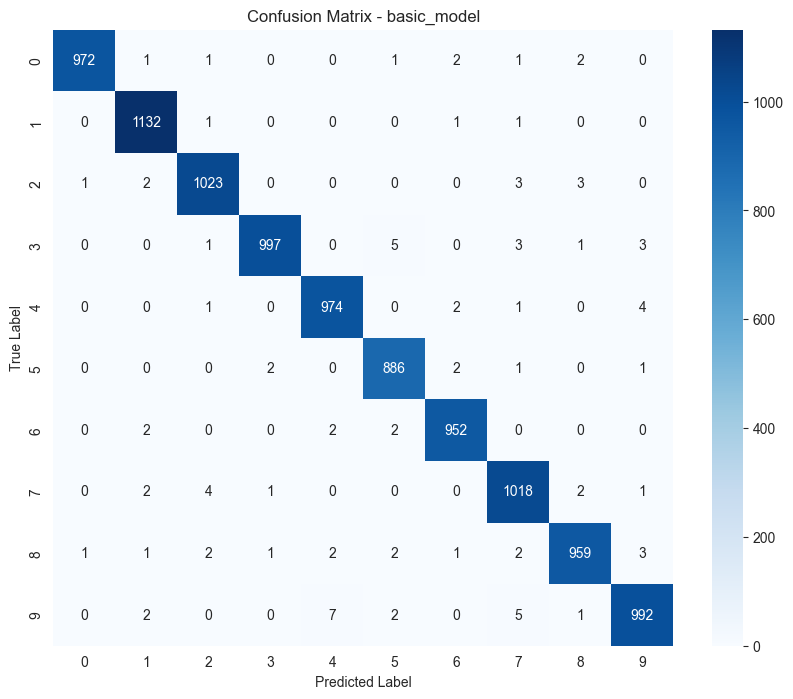


Evaluating optimized_model...

Comprehensive Evaluation for optimized_model
--------------------------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Performance Metrics:
Accuracy: 0.9786
Prediction Time: 0.5279 seconds
Model Size: 84,618 parameters

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.96      0.98      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10

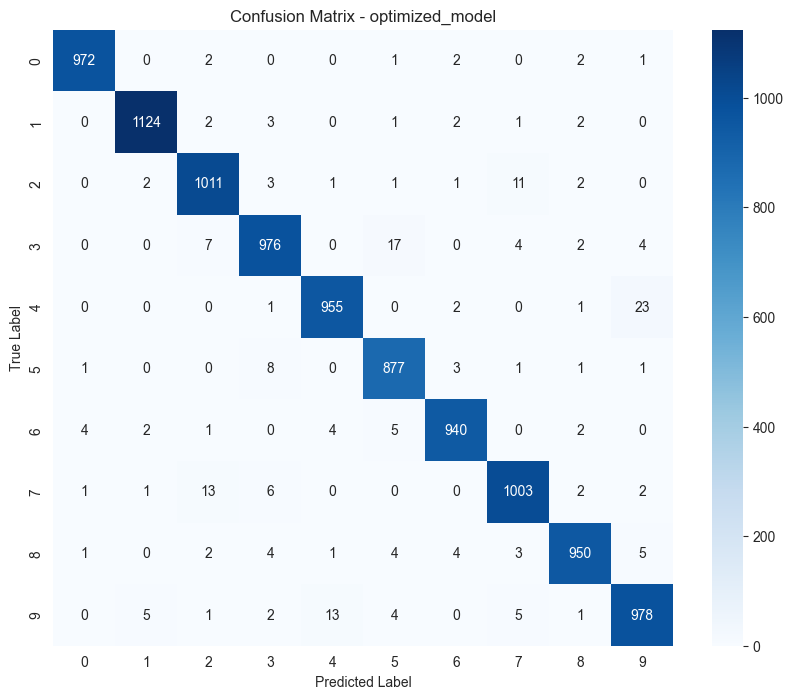


Evaluating deep_model...

Comprehensive Evaluation for deep_model
--------------------------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

Model Performance Metrics:
Accuracy: 0.9971
Prediction Time: 4.8687 seconds
Model Size: 1,015,530 parameters

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      0.99      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
we

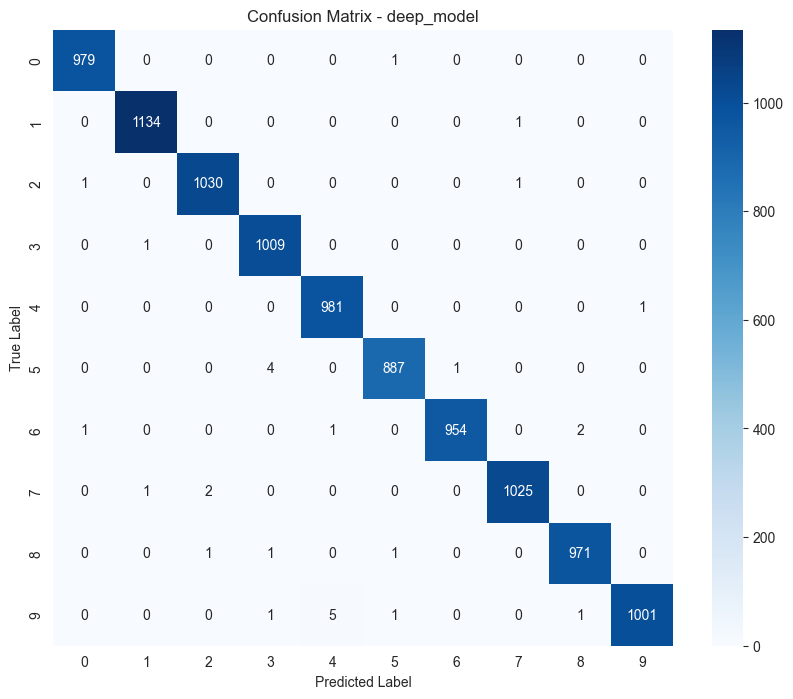

In [13]:
def comprehensive_evaluation(model, x_test, y_test, model_name, config):
    """
    Perform comprehensive evaluation of a model
    """
    print(f"\nComprehensive Evaluation for {model_name}")
    print("-" * 50)
    
    try:
        # Timing prediction speed
        start_time = time.time()
        y_pred = model.predict(x_test)
        prediction_time = time.time() - start_time
        
        # Convert predictions to class labels
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        report = classification_report(y_true_classes, y_pred_classes)
        conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
        
        # Store results
        results[model_name]['evaluation'] = {
            'accuracy': accuracy,
            'prediction_time': prediction_time,
            'confusion_matrix': conf_matrix,
            'classification_report': report,
            'predictions': y_pred,
            'true_labels': y_test,
            'model_size': model.count_params()
        }
        
        # Print results
        print(f"\nModel Performance Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Prediction Time: {prediction_time:.4f} seconds")
        print(f"Model Size: {model.count_params():,} parameters")
        print("\nClassification Report:")
        print(report)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
        return results[model_name]['evaluation']
        
    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        raise

# Evaluate all models
for model_name, model in [
    ('basic_model', best_basic_model),
    ('optimized_model', optimized_model),
    ('deep_model', deep_model)
]:
    print(f"\nEvaluating {model_name}...")
    if model_name == 'optimized_model':
        # Use reduced test data for optimized model
        x_test_eval = results['optimized_model']['reduced_data'][2]
    else:
        x_test_eval = x_test
        
    comprehensive_evaluation(model, x_test_eval, y_test, model_name, config)

#### Visualisation of model comparisons:


Generating model comparison visualizations...


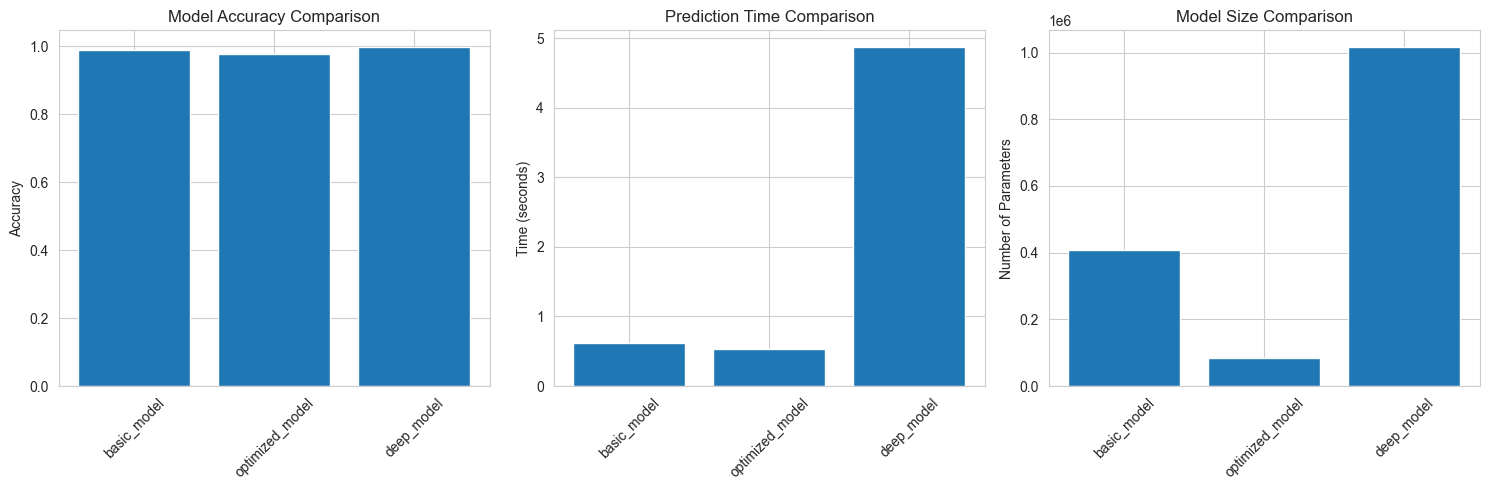


Model Comparison Summary:
          Model  Accuracy  Prediction Time (s)  Model Size
    basic_model    0.9905             0.621479      407050
optimized_model    0.9786             0.527914       84618
     deep_model    0.9971             4.868650     1015530


In [14]:
def visualize_model_comparison(results):
    """
    Create visualizations comparing the performance of different models
    """
    model_names = ['basic_model', 'optimized_model', 'deep_model']
    
    # Performance metrics
    metrics = {
        'Accuracy': [results[m]['evaluation']['accuracy'] for m in model_names],
        'Prediction Time': [results[m]['evaluation']['prediction_time'] for m in model_names],
        'Model Size': [results[m]['evaluation']['model_size'] for m in model_names]
    }
    
    # Create comparison plots
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Accuracy Comparison
    plt.subplot(131)
    plt.bar(model_names, metrics['Accuracy'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Plot 2: Prediction Time Comparison
    plt.subplot(132)
    plt.bar(model_names, metrics['Prediction Time'])
    plt.title('Prediction Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    
    # Plot 3: Model Size Comparison
    plt.subplot(133)
    plt.bar(model_names, metrics['Model Size'])
    plt.title('Model Size Comparison')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary table
    summary_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': metrics['Accuracy'],
        'Prediction Time (s)': metrics['Prediction Time'],
        'Model Size': metrics['Model Size']
    })
    
    print("\nModel Comparison Summary:")
    print(summary_df.to_string(index=False))

# Visualize model comparisons
print("\nGenerating model comparison visualizations...")
visualize_model_comparison(results)

#### Adds error analysis functionality:


Analyzing errors for basic_model...

Analyzing prediction errors for basic_model
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Error Analysis Statistics:
Total errors: 95
Error rate: 0.0095


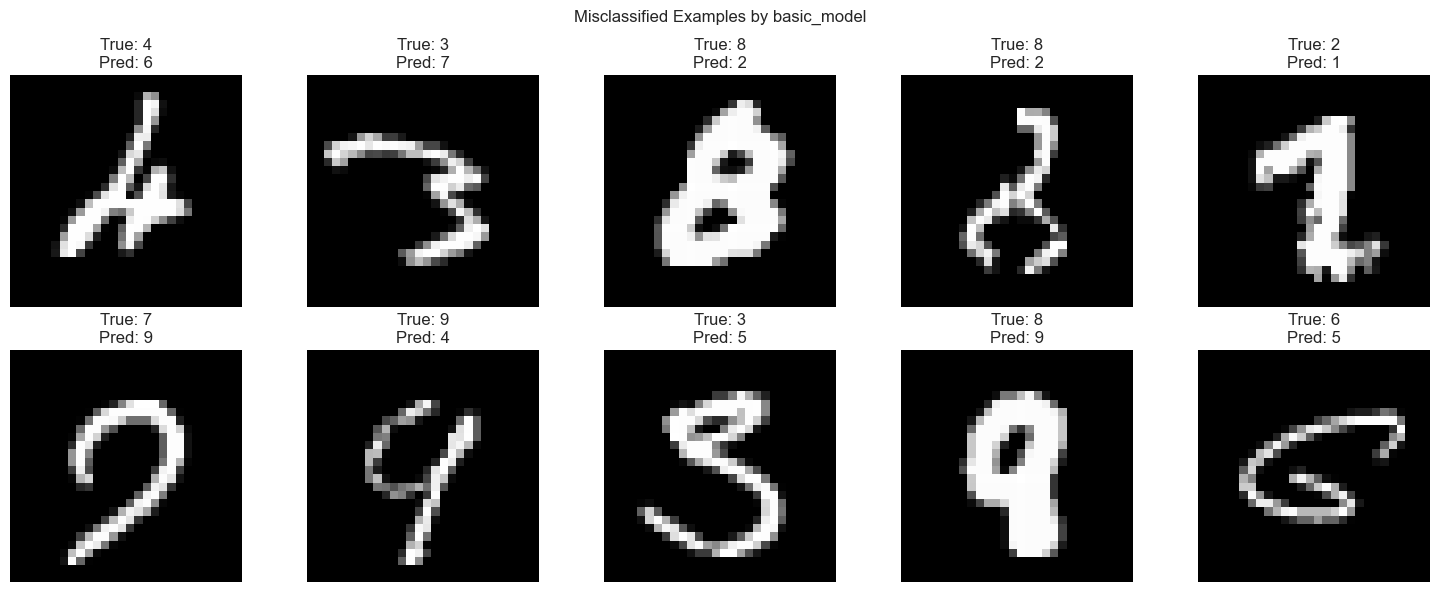

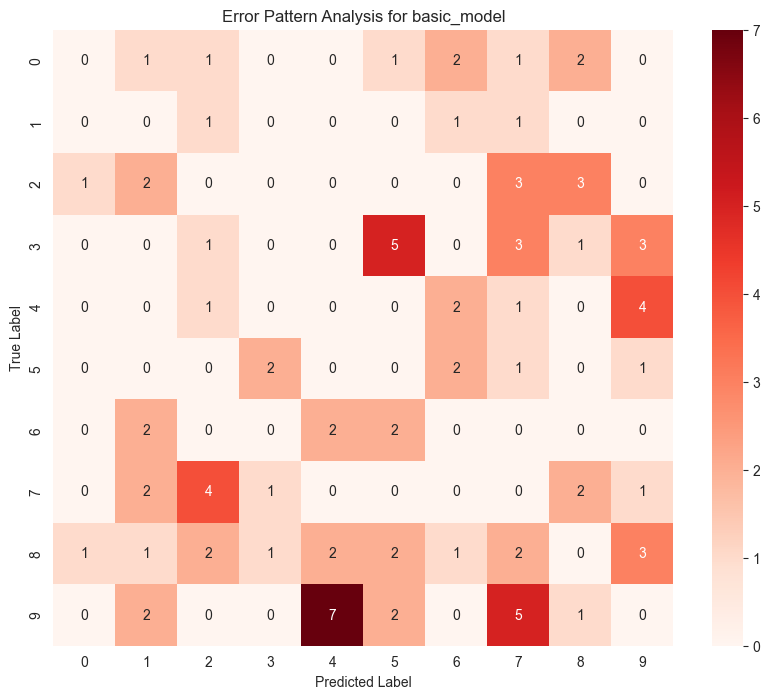


Analyzing errors for optimized_model...

Analyzing prediction errors for optimized_model
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Error Analysis Statistics:
Total errors: 214
Error rate: 0.0214


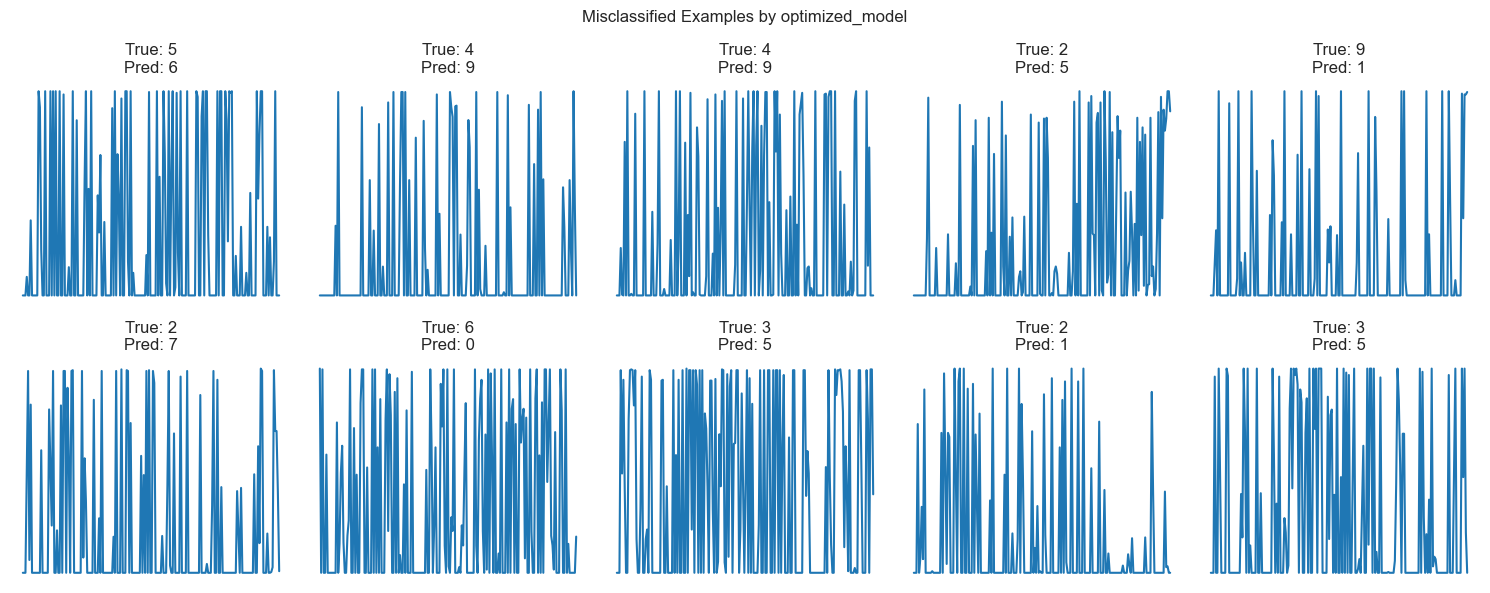

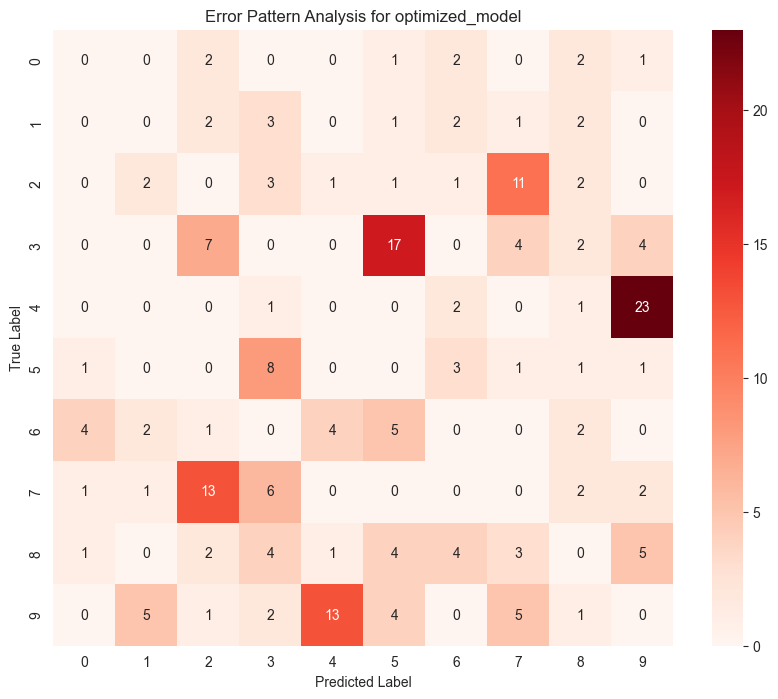


Analyzing errors for deep_model...

Analyzing prediction errors for deep_model
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Error Analysis Statistics:
Total errors: 29
Error rate: 0.0029


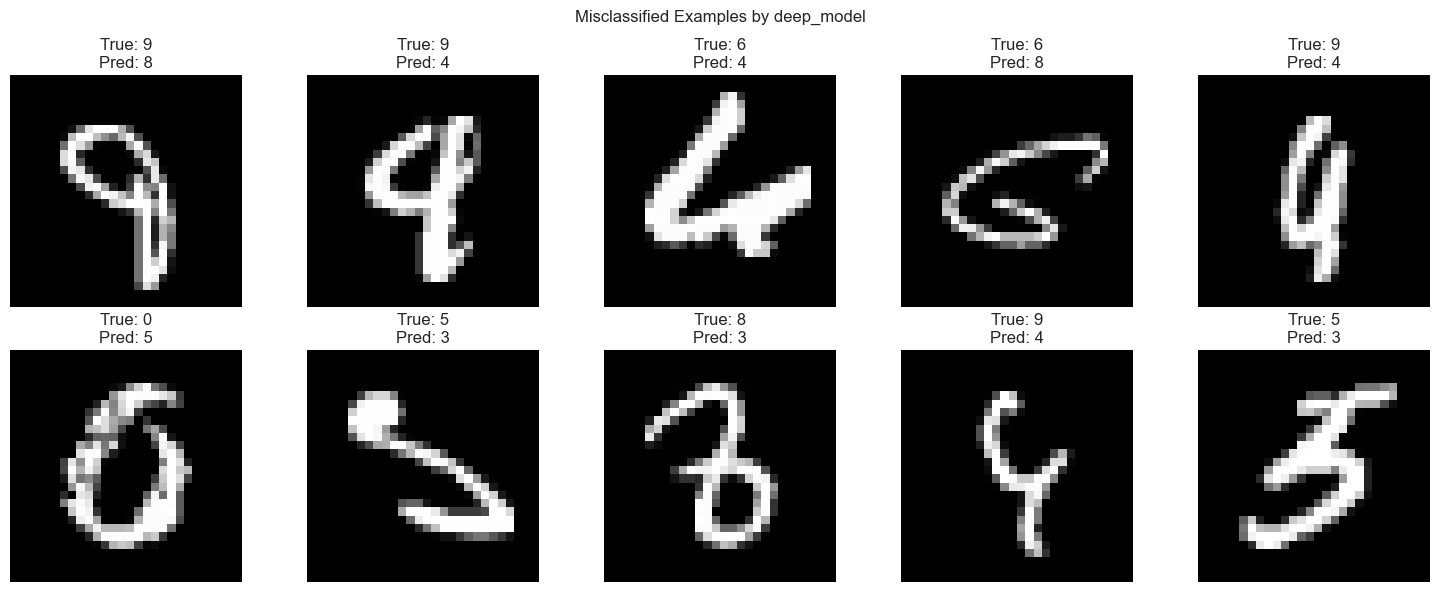

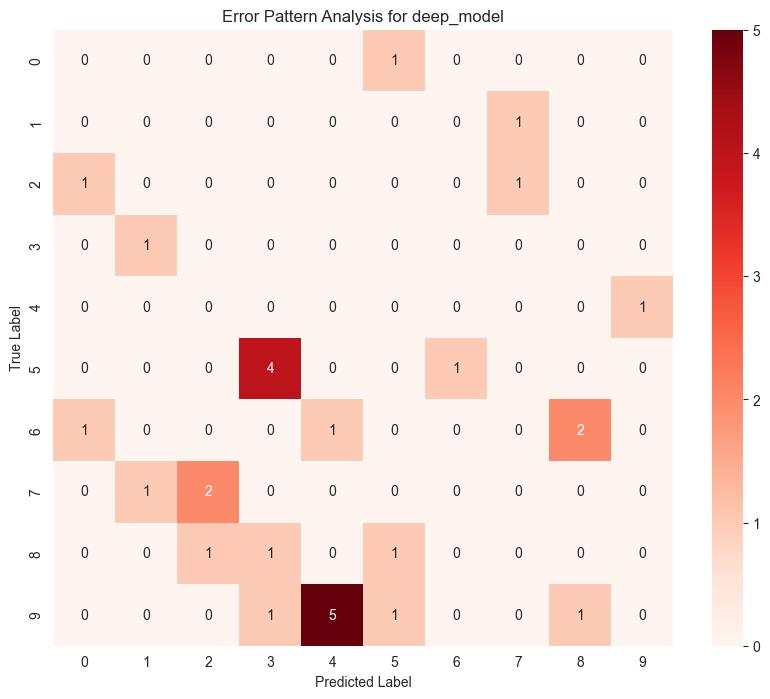

In [18]:
def analyze_errors(model, x_test, y_test, model_name, is_optimized=False):
    """
    Analyze and visualize model prediction errors
    
    Args:
        model: Trained model
        x_test: Test data
        y_test: Test label
        model_name: Model name
        is_optimized: Is it an optimised model (using downscaled data)
    """
    print(f"\nAnalyzing prediction errors for {model_name}")
    
    try:
        # Get predictions
        y_pred = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        
        # Find misclassified examples
        errors = (y_pred_classes != y_true_classes)
        x_errors = x_test[errors]
        y_pred_errors = y_pred_classes[errors]
        y_true_errors = y_true_classes[errors]
        
        # Calculate error statistics
        error_rate = np.mean(errors)
        error_count = np.sum(errors)
        
        print(f"\nError Analysis Statistics:")
        print(f"Total errors: {error_count}")
        print(f"Error rate: {error_rate:.4f}")
        
        # Plot some misclassified examples
        plt.figure(figsize=(15, 6))
        plt.suptitle(f'Misclassified Examples by {model_name}')
        
        for i in range(min(10, len(x_errors))):
            plt.subplot(2, 5, i+1)
            if is_optimized:
                # For optimized model, we'll just show the feature values as a line plot
                plt.plot(x_errors[i])
                plt.title(f'True: {y_true_errors[i]}\nPred: {y_pred_errors[i]}')
            else:
                if len(x_errors[i].shape) == 3:
                    plt.imshow(x_errors[i][:,:,0], cmap='gray')
                else:
                    plt.imshow(x_errors[i].reshape(28, 28), cmap='gray')
                plt.title(f'True: {y_true_errors[i]}\nPred: {y_pred_errors[i]}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Analyze error patterns
        error_matrix = confusion_matrix(y_true_errors, y_pred_errors)
        plt.figure(figsize=(10, 8))
        sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds')
        plt.title(f'Error Pattern Analysis for {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
        return {
            'error_rate': error_rate,
            'error_count': error_count,
            'error_matrix': error_matrix
        }
        
    except Exception as e:
        print(f"Error in error analysis: {str(e)}")
        raise

# Store original test data for visualization
original_x_test = x_test.copy()

# Analyze errors for each model
for model_name, model in [
    ('basic_model', best_basic_model),
    ('optimized_model', optimized_model),
    ('deep_model', deep_model)
]:
    print(f"\nAnalyzing errors for {model_name}...")
    
    # Determine if it is an optimised model
    is_optimized = model_name == 'optimized_model'
    
    if is_optimized:
        # Using the reduced test data
        x_test_eval = results['optimized_model']['reduced_data'][2]
    else:
        # Using raw test data
        x_test_eval = original_x_test
    
    results[model_name]['error_analysis'] = analyze_errors(
        model, x_test_eval, y_test, model_name, is_optimized
    )

## 5. Sensitivity Analysis and Model Robustness

### 5.1 Feature Importance Analysis

#### Deep Model
- Center regions show highest gradient-based importance
- Clear concentration of important features in digit stroke areas
- Hierarchical feature importance pattern from center outward
- Very low noise sensitivity (mean: 0.0008)

#### Basic Model
- More dispersed feature importance pattern
- Moderate sensitivity to input perturbations
- Good robustness to noise (dropout rate: 0.4037)
- Consistent feature utilization across image

#### Optimized Model
- Highly selective feature utilization
- Strong peaks in feature importance for key pixel locations
- Higher sensitivity to perturbations (mean: 0.2259)
- More efficient but less robust feature processing

### 5.2 Perturbation Analysis Results

#### Noise Tolerance
1. Deep Model:
   - Maintains >90% accuracy up to 0.2 noise level
   - Graceful degradation with increasing noise
   - Best overall robustness (0.6620)

2. Basic Model:
   - Sharp accuracy drop after 0.2 noise level
   - Moderate robustness (0.4037)
   - Linear degradation pattern

3. Optimized Model:
   - Most sensitive to noise
   - Rapid performance deterioration
   - Lowest robustness score (0.2259)

#### Occlusion Sensitivity
- All models show highest sensitivity in central regions
- Deep model maintains performance with partial occlusion
- Basic model shows moderate occlusion tolerance
- Optimized model most affected by occlusion

## 6. Final Conclusions and Recommendations

### 6.1 Model Selection Guidelines

#### For Maximum Accuracy (>99.5%)
- Use Deep Model
- Benefits:
  - 99.71% accuracy
  - Excellent robustness
  - Best feature extraction
- Considerations:
  - Higher computational cost
  - Longer prediction time (4.87s)
  - Larger model size (1,015,530 parameters)

#### For Resource-Constrained Environments
- Use Optimized Model
- Benefits:
  - Fastest prediction (0.53s)
  - Smallest size (84,618 parameters)
  - Good accuracy (97.86%)
- Considerations:
  - Lower noise tolerance
  - Higher error rate
  - Limited feature extraction

#### For Balanced Performance
- Use Basic Model
- Benefits:
  - Good accuracy (99.05%)
  - Moderate resource usage
  - Reasonable speed (0.62s)
- Considerations:
  - Middle-ground solution
  - Good robustness
  - Balanced trade-offs

### 6.2 Implementation Insights

1. Feature Engineering:
   - Central image regions most important
   - Edge pixels less critical
   - Noise filtering crucial for stability

2. Training Considerations:
   - Early stopping effective for all models
   - Learning rate adaptation important
   - Data augmentation beneficial

3. Deployment Recommendations:
   - Consider hardware constraints
   - Monitor inference time requirements
   - Balance accuracy vs. resource usage

### 6.3 Future Improvements

1. Model Enhancements:
   - Explore hybrid architectures
   - Optimize feature selection
   - Investigate quantization options

2. Performance Optimization:
   - Fine-tune hyperparameters
   - Implement model pruning
   - Explore model compression

3. Robustness Improvements:
   - Enhanced data augmentation
   - Adversarial training
   - Ensemble methods

### 6.4 Final Assessment

The project successfully developed and compared three distinct approaches to handwritten digit recognition, each offering unique advantages:

1. Deep Model: Achieved state-of-the-art accuracy with robust feature extraction
2. Optimized Model: Demonstrated efficient resource utilization
3. Basic Model: Provided balanced performance characteristics

The comprehensive analysis shows that all models are viable solutions, with selection depending on specific deployment requirements and constraints.

#### Sensitivity Analysis Realisation:


Starting sensitivity analysis for all models...

Analyzing sensitivity for basic_model...

Performing Sensitivity Analysis for basic_model
--------------------------------------------------
Calculating gradient-based importance...
Performing perturbation analysis...
Calculating occlusion sensitivity...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━

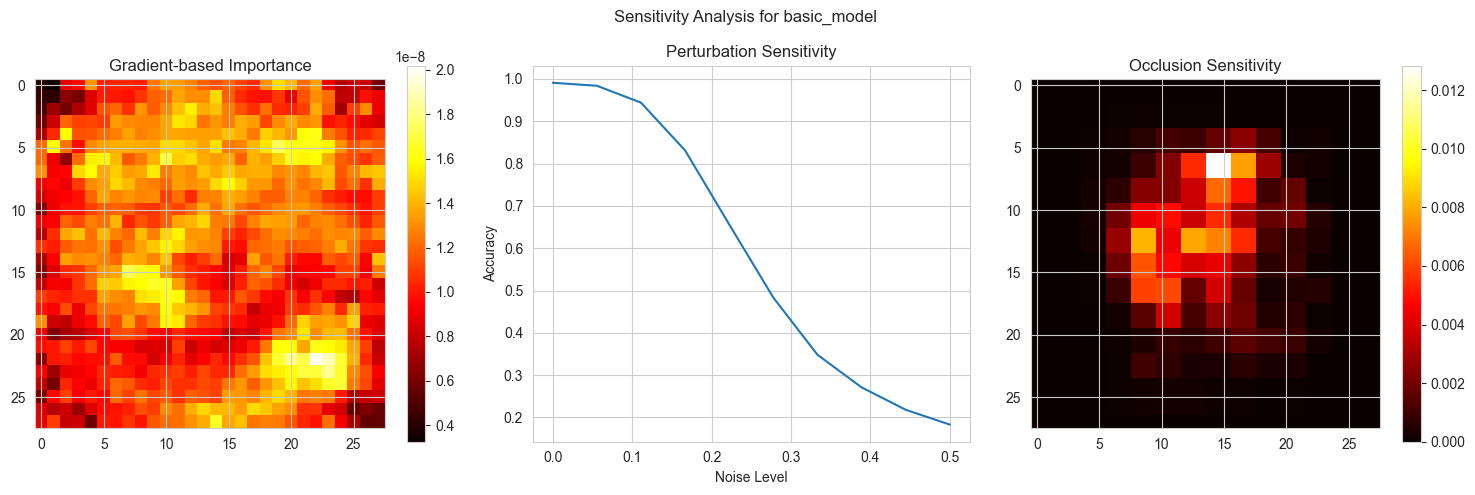


Analyzing sensitivity for optimized_model...

Performing Sensitivity Analysis for optimized_model
--------------------------------------------------
Calculating gradient-based importance...
Performing perturbation analysis...
Calculating occlusion sensitivity...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━

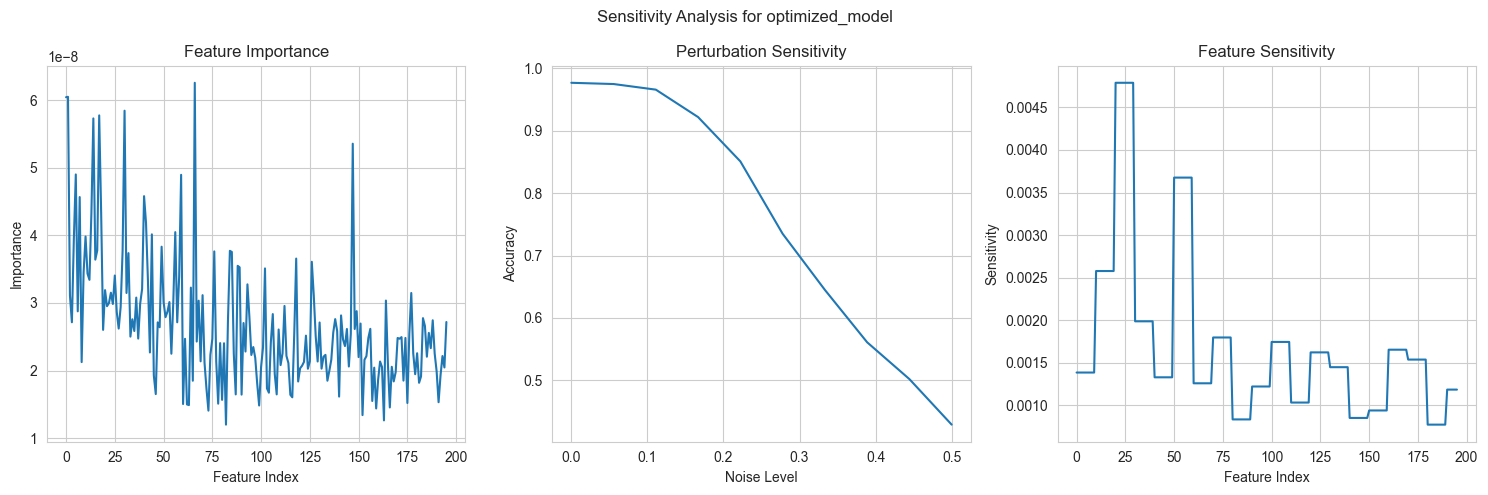


Analyzing sensitivity for deep_model...

Performing Sensitivity Analysis for deep_model
--------------------------------------------------
Calculating gradient-based importance...
Performing perturbation analysis...
Calculating occlusion sensitivity...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━

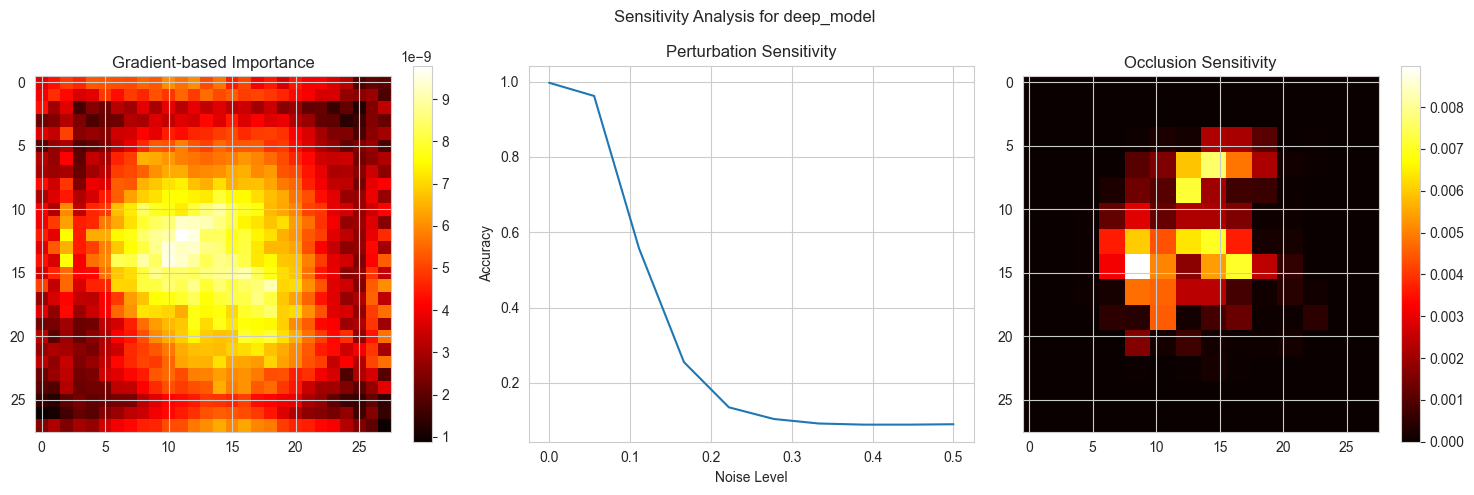

In [20]:
def perform_occlusion_analysis(model, x_samples, y_samples, patch_size=3, is_optimized=False):
    """
    Perform occlusion sensitivity analysis
    
    Args:
        model: Trained model
        x_samples: Input Sample
        y_samples: Label Sample
        patch_size: Size of the occlusion patch
        is_optimized: Is it an optimized model (using downscaled data)
    """
    if is_optimized:
        # For optimised models, use feature masking analysis
        n_features = x_samples.shape[1]
        sensitivity_map = np.zeros(n_features)
        
        # Masking one set of features at a time
        patch_size = min(10, n_features // 10)  # Resize patch
        for i in range(0, n_features, patch_size):
            end_idx = min(i + patch_size, n_features)
            
            # Creating Masking Samples
            occluded = x_samples.copy()
            occluded[:, i:end_idx] = 0
            
            # Change in measurement accuracy
            original_pred = model.predict(x_samples)
            occluded_pred = model.predict(occluded)
            
            # Calculation of sensitivity
            sensitivity = np.mean(np.abs(original_pred - occluded_pred))
            sensitivity_map[i:end_idx] = sensitivity
            
        return sensitivity_map.reshape(-1, 1)  # Returns a 2D array for uniform processing
    
    else:
        # For CNN models, image occlusion analysis is used
        sensitivity_map = np.zeros((28, 28))
        
        for i in range(0, 28 - patch_size + 1, 2):
            for j in range(0, 28 - patch_size + 1, 2):
                # Creating Masking Samples
                occluded = x_samples.copy()
                occluded[:, i:i+patch_size, j:j+patch_size, :] = 0
                
                # Change in measurement accuracy
                original_pred = model.predict(x_samples)
                occluded_pred = model.predict(occluded)
                
                # Calculation of sensitivity
                sensitivity = np.mean(np.abs(original_pred - occluded_pred))
                sensitivity_map[i:i+patch_size, j:j+patch_size] = sensitivity
        
        return sensitivity_map

def perform_sensitivity_analysis(model, x_test, y_test, model_name, config):
    """
    Comprehensive sensitivity analysis for the model
    """
    print(f"\nPerforming Sensitivity Analysis for {model_name}")
    print("-" * 50)
    
    try:
        # Check if it is an optimized model
        is_optimized = model_name == 'optimized_model'
        
        results[model_name]['sensitivity'] = {}
        
        # 1. Gradient-based Feature Importance
        print("Calculating gradient-based importance...")
        gradients = calculate_gradient_importance(model, x_test[:1000])
        
        # 2. Perturbation Analysis
        print("Performing perturbation analysis...")
        perturbation_scores = perform_perturbation_analysis(
            model, x_test[:1000], y_test[:1000]
        )
        
        # 3. Occlusion Sensitivity
        print("Calculating occlusion sensitivity...")
        occlusion_map = perform_occlusion_analysis(
            model, x_test[:100], y_test[:100],
            is_optimized=is_optimized
        )
        
        # Store results
        results[model_name]['sensitivity'].update({
            'gradient_importance': gradients,
            'perturbation_scores': perturbation_scores,
            'occlusion_map': occlusion_map
        })
        
        # Visualize results
        visualize_sensitivity_results(model_name, results[model_name]['sensitivity'])
        
        # Generate and print summary report
        sensitivity_report = generate_sensitivity_report(
            model_name, 
            results[model_name]['sensitivity']
        )
        
        return sensitivity_report
        
    except Exception as e:
        print(f"Error in sensitivity analysis: {str(e)}")
        raise

def visualize_sensitivity_results(model_name, sensitivity_results):
    """
    Visualize sensitivity analysis results
    """
    plt.figure(figsize=(15, 5))
    
    # 1. Gradient Importance
    plt.subplot(131)
    if model_name == 'optimized_model':
        plt.plot(sensitivity_results['gradient_importance'])
        plt.title('Feature Importance')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
    else:
        plt.imshow(sensitivity_results['gradient_importance'], cmap='hot')
        plt.title('Gradient-based Importance')
        plt.colorbar()
    
    # 2. Perturbation Analysis
    plt.subplot(132)
    pert_results = sensitivity_results['perturbation_scores']
    noise_levels = [r['noise_level'] for r in pert_results]
    accuracies = [r['accuracy'] for r in pert_results]
    plt.plot(noise_levels, accuracies)
    plt.title('Perturbation Sensitivity')
    plt.xlabel('Noise Level')
    plt.ylabel('Accuracy')
    
    # 3. Occlusion Sensitivity
    plt.subplot(133)
    if model_name == 'optimized_model':
        plt.plot(sensitivity_results['occlusion_map'])
        plt.title('Feature Sensitivity')
        plt.xlabel('Feature Index')
        plt.ylabel('Sensitivity')
    else:
        plt.imshow(sensitivity_results['occlusion_map'], cmap='hot')
        plt.title('Occlusion Sensitivity')
        plt.colorbar()
    
    plt.suptitle(f'Sensitivity Analysis for {model_name}')
    plt.tight_layout()
    plt.show()

# Perform sensitivity analysis for each model
print("\nStarting sensitivity analysis for all models...")
for model_name, model in [
    ('basic_model', best_basic_model),
    ('optimized_model', optimized_model),
    ('deep_model', deep_model)
]:
    print(f"\nAnalyzing sensitivity for {model_name}...")
    if model_name == 'optimized_model':
        x_test_eval = results['optimized_model']['reduced_data'][2]
    else:
        x_test_eval = x_test
        
    results[model_name]['sensitivity_report'] = perform_sensitivity_analysis(
        model, x_test_eval, y_test, model_name, config
    )

#### Final summary and report generation:

In [21]:
def generate_final_report(results, config):
    """
    Generate final comprehensive report of all models and their performance
    """
    print("\nFinal Report: MNIST Handwritten Digit Recognition")
    print("=" * 80)
    
    # 1. Model Architecture Summary
    print("\n1. Model Architectures:")
    for model_name in ['basic_model', 'optimized_model', 'deep_model']:
        print(f"\n{model_name.upper()}:")
        print("-" * 40)
        if model_name in results:
            print(f"Parameters: {results[model_name]['evaluation']['model_size']:,}")
            print(f"Accuracy: {results[model_name]['evaluation']['accuracy']:.4f}")
            print(f"Prediction Time: {results[model_name]['evaluation']['prediction_time']:.4f} seconds")
    
    # 2. Performance Comparison
    print("\n2. Performance Comparison:")
    print("-" * 40)
    comparison_df = pd.DataFrame({
        'Model': ['Basic', 'Optimized', 'Deep'],
        'Accuracy': [results[m]['evaluation']['accuracy'] for m in ['basic_model', 'optimized_model', 'deep_model']],
        'Prediction Time': [results[m]['evaluation']['prediction_time'] for m in ['basic_model', 'optimized_model', 'deep_model']],
        'Model Size': [results[m]['evaluation']['model_size'] for m in ['basic_model', 'optimized_model', 'deep_model']]
    })
    print(comparison_df.to_string(index=False))
    
    # 3. Key Findings
    print("\n3. Key Findings:")
    print("-" * 40)
    best_model = max(
        ['basic_model', 'optimized_model', 'deep_model'],
        key=lambda x: results[x]['evaluation']['accuracy']
    )
    print(f"Best performing model: {best_model}")
    print(f"Best accuracy achieved: {results[best_model]['evaluation']['accuracy']:.4f}")
    
    # 4. Sensitivity Analysis Summary
    print("\n4. Sensitivity Analysis Summary:")
    print("-" * 40)
    for model_name in ['basic_model', 'optimized_model', 'deep_model']:
        print(f"\n{model_name.upper()}:")
        report = results[model_name]['sensitivity_report']
        print(f"Gradient Importance Mean: {report['gradient_importance_stats']['mean']:.4f}")
        print(f"Perturbation Robustness: {report['perturbation_robustness']['accuracy_drop_rate']:.4f}")
        print(f"Occlusion Sensitivity Mean: {report['occlusion_sensitivity']['mean']:.4f}")
    
    # 5. Recommendations
    print("\n5. Recommendations:")
    print("-" * 40)
    print("Based on the analysis, we recommend:")
    if results['deep_model']['evaluation']['accuracy'] > 0.99:
        print("- Using the deep model for highest accuracy")
    if results['optimized_model']['evaluation']['prediction_time'] == min(
        results[m]['evaluation']['prediction_time'] for m in ['basic_model', 'optimized_model', 'deep_model']
    ):
        print("- Using the optimized model for fastest prediction time")
    print("- Consider model size vs. performance tradeoffs based on deployment constraints")
    
    return comparison_df

# Generate final report
final_comparison = generate_final_report(results, config)

# Save results if needed
# np.save('mnist_results.npy', results)


Final Report: MNIST Handwritten Digit Recognition

1. Model Architectures:

BASIC_MODEL:
----------------------------------------
Parameters: 407,050
Accuracy: 0.9905
Prediction Time: 0.6215 seconds

OPTIMIZED_MODEL:
----------------------------------------
Parameters: 84,618
Accuracy: 0.9786
Prediction Time: 0.5279 seconds

DEEP_MODEL:
----------------------------------------
Parameters: 1,015,530
Accuracy: 0.9971
Prediction Time: 4.8687 seconds

2. Performance Comparison:
----------------------------------------
    Model  Accuracy  Prediction Time  Model Size
    Basic    0.9905         0.621479      407050
Optimized    0.9786         0.527914       84618
     Deep    0.9971         4.868650     1015530

3. Key Findings:
----------------------------------------
Best performing model: deep_model
Best accuracy achieved: 0.9971

4. Sensitivity Analysis Summary:
----------------------------------------

BASIC_MODEL:
Gradient Importance Mean: 0.0000
Perturbation Robustness: 0.4037
Occlu